# Let's Talk Data!

Marketing. Is. Tough. 

Identifying a viable demographic - is no small feat. 

Introducing, [TalkData](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/overview)! 

This project is to construct a product as a working machine learning model that can be used to predict the demographic of the individuals who have participated in this device plan. The plan provides the users' location coordinates, time they accessed the app, phone brand, phone model, applications that they're using, the category those applications belong to, and indicates whether or not the applications are in use. 

I will be using machine learning techniques to uncover the users' demographic group - consisting of a label that references their gender and age. This is a product that could be used, for example, by a telecommunications provider to identify their 小米 demographic and tailor the advertisements as such.

*the data is available on Kaggle at the link above. It has been processed in a separate file.*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
#A summary of missing variables represented as a percentage of the total missing content. 
def null_summary(df, print_log=False, sort='ascending'):
    s = df.isnull().sum()*100/df.isnull().count()
    
    if sort.lower() == 'ascending':
        s = s.sort_values(ascending=True)
    elif sort.lower() == 'descending':
        s = s.sort_values(ascending=False)  
    if print_log: 
        print('Percentage of null values: \n', s)
  
    return pd.Series(s)

In [16]:
#get the data
talkdata = pd.read_csv('./data/talkdata.csv')
#Quick look at the head.
talkdata.head()

,timestamp,longitude,latitude,coordinates,is_active,phone_brand,device_model,category,gender,age,group
0,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,1 free,M,35,M32-38
1,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,Cozy 1,M,35,M32-38
2,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,Industry tag,M,35,M32-38
3,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,Property Industry 2.0,M,35,M32-38
4,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,music,M,35,M32-38


In [4]:
#The size and shape of this dataset before categorical changing.
talkdata.shape

(7832282, 11)

In the previous module, I recognized my target (prediction variables) as the age, gender, or group; which is a combination of both the age and the age range that the individuals are in. 

In [18]:
#the variables I think I'm targeting.
target_vars = ['age', 'gender', 'group']

In [6]:
#check for null values.
null_summary(talkdata)

timestamp       0.0
longitude       0.0
latitude        0.0
coordinates     0.0
is_active       0.0
phone_brand     0.0
device_model    0.0
category        0.0
gender          0.0
age             0.0
group           0.0
dtype: float64

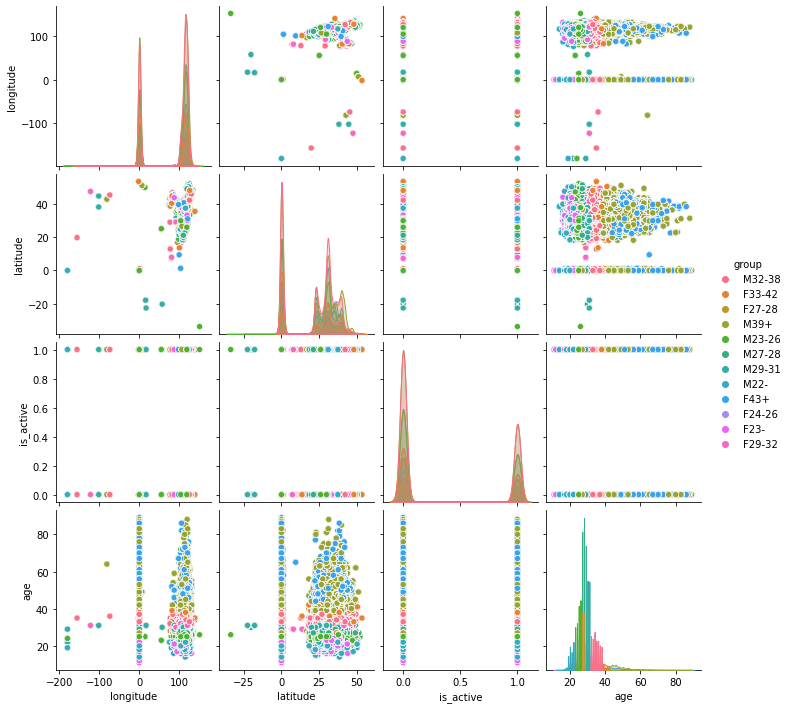

In [17]:
#get an idea of what these conintuous variables look like. 
sns.pairplot(data=talkdata, hue='group')
plt.show()

The pair plot provided, indicates that a more inactive applications reporting than I do active applications reportng. 

The ages are not normally distributed, the number of inactive applications has little to do with the age of these individiuals, and I have a lot of mobile devices. That is; the devices can be located anywhere in the world. With this dataset, a mose of them appear to be between 0-130 long and 0 - 55 lat. 

In [21]:
talkdata.nunique()

timestamp       497663
longitude         2914
latitude          2707
coordinates      32921
is_active            2
phone_brand         89
device_model       926
category           441
gender               2
age                 78
group               12
dtype: int64

There are over 400 categories, quite a few coordinates. I have a lot of devices and phone brands. 

In [19]:
#Time conversion so it's easier to work with the datetime data.
talkdata['tTime'] = pd.to_datetime(talkdata.timestamp)

In [20]:
#Just in case.
talkdata['epoch'] = talkdata['tTime'].astype('int64')

In [250]:
#Sample collection information.
print(f"{(talkdata.tTime.max() - talkdata.tTime.min())} of data collection from {talkdata.tTime.min()} to {talkdata.tTime.max()}")
print(f"Male contribution: {men.gender.count()}")
print(f"Female contribution: {women.gender.count()}")
print(f"Age ranges from {talkdata.age.min()} to {talkdata.age.max()}")

7 days 00:07:44 of data collection from 2016-04-30 23:52:24 to 2016-05-08 00:00:08
Male contribution: 5566437
Female contribution: 2265845
Age ranges from 11 to 89


In [157]:
print(f"Total of {talkdata.group.nunique()} demographic groups")
talkdata.group.value_counts().sort_index()

Total of 12 demographic groups


F23-       284307
F24-26     293253
F27-28     265227
F29-32     368179
F33-42     569174
F43+       485705
M22-       478388
M23-26     891726
M27-28     573394
M29-31     906111
M32-38    1356099
M39+      1360719
Name: group, dtype: int64

My data set has more input from male users than female users. I have a large age range. I already know from the pairplot that the age distribution is not quite normal. These are my target (prediction) variables. Without doing some triage, I will likely see bias in favor of male predictions. I have reached out for assistance with this. I will construct the model using X_train split and the stratisy method. If I do not see any improvements - I may want included an [imbalanced pipeline](https://imbalanced-learn.org/stable/api.html) in my gridsearch. 

In [353]:
#does the phone_brand depend on the model? 
investigation = talkdata[['device_model', 'phone_brand']].groupby(by='device_model').nunique()
investigation[investigation.phone_brand > 1]

,phone_brand
device_model,
A880,2
M8,2
N1,2
One,2
P9,2
R1,3
S2,2
S3,2
S6,3


In [361]:
talkdata[talkdata.device_model == 'A880'].phone_brand.value_counts()

中兴    2736
联想     402
Name: phone_brand, dtype: int64

In [364]:
#concatenate the phone brand to the device model. 
talkdata['device_type'] = talkdata.phone_brand + " "+ talkdata.device_model

In [367]:
talkdata['device_type'].value_counts()

华为 荣耀6           354430
华为 荣耀畅玩4X        296766
华为 Mate 7        276943
小米 MI 4          264082
小米 红米note        247545
                  ...  
索尼 X10i               2
海信 U966               2
酷派 5956               1
海信 E600M              1
联想 TAB A10-80         1
Name: device_type, Length: 942, dtype: int64

In [372]:
#Graph Settings for gender based observations.
men = talkdata[talkdata.gender == 'M']
women = talkdata[talkdata.gender == 'F']

#Set the font to display phone brands and models.
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
sns.set(font="SimSun")

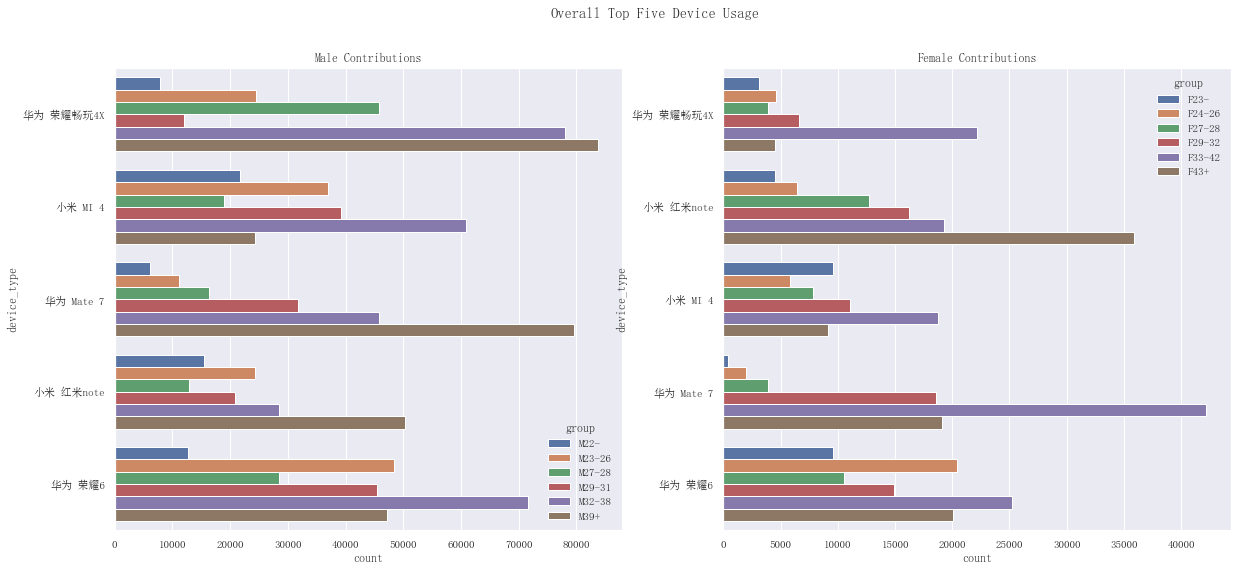

In [373]:
top_five = talkdata.device_type.value_counts().nlargest(5).keys()

#Split the count plot.
fig,ax =  plt.subplots(1,2, figsize=(20,8.5))
plt.suptitle('Overall Top Five Device Usage')
sns.countplot(y='device_type', 
            data=men[men.device_type.isin(top_five)], 
            hue='group', hue_order = men.group.value_counts().index.sort_values(),
            ax=ax[0]).set_title('Male Contributions')

sns.countplot(y='device_type', 
            data=women[women.device_type.isin(top_five)], 
            hue='group', hue_order = women.group.value_counts().index.sort_values(),
            ax=ax[1]).set_title("Female Contributions")
plt.show()

In [208]:
#for analysing how these categories relate to the time variable. 
time_data = talkdata.set_index('tTime')

In [209]:
time_data.nunique()

timestamp       497663
longitude         2914
latitude          2707
coordinates      32921
is_active            2
phone_brand         89
device_model       926
category           441
gender               2
age                 78
group               12
epoch           497663
dtype: int64

In [210]:
#function for the heatmap on time data.
def heatmap(df, length=8, width=18, title=''):
    plt.figure(figsize=(width,length))
    ax = sns.heatmap(df, annot=True, fmt='.1f', cmap='Reds', linewidths=.01)
    plt.title(title + "\n", fontsize=16)

In [251]:
#set up for accessing by hour, day, or week.
time_data['hour'] = time_data.index.hour
time_data['week'] = time_data.index.dayofweek
time_data['month'] = time_data.index.month

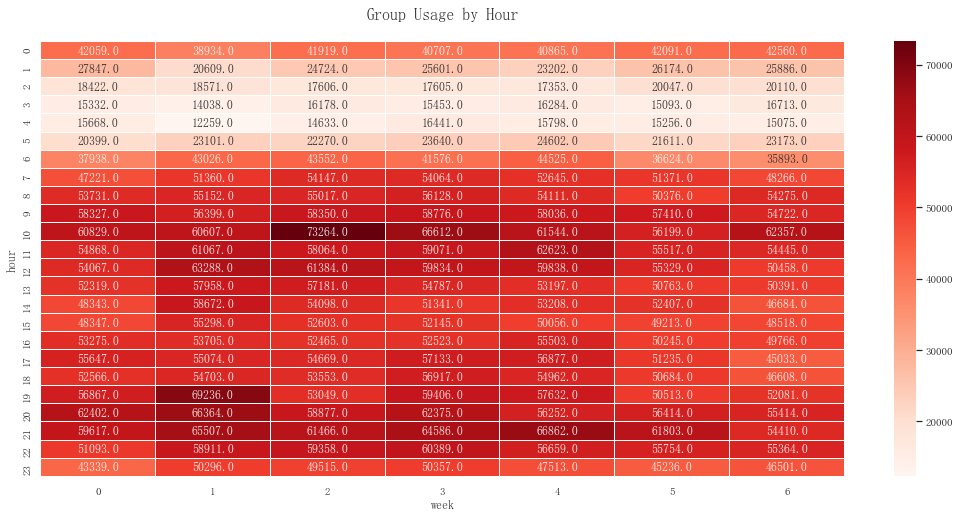

In [253]:
#demographic by time of day. 
heatmap_df = time_data.pivot_table(index='hour', columns='week', values='group', aggfunc='count')
heatmap(heatmap_df, title='Group Usage by Hour')

More events occur between monday and friday, lower usage is done by the hour and there are peaks of events here and there. 

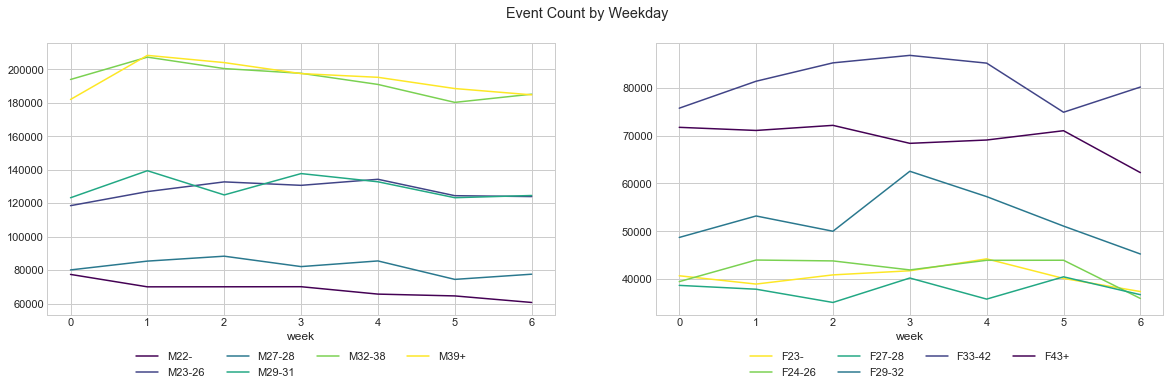

In [330]:
#Demographic by day of week, split by gender.
f, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,5))

plt.suptitle("Event Count by Weekday")

time_data[time_data.gender == 'M'].pivot_table(index='week', columns='group', values='age', aggfunc='count').plot(ax=ax1, cmap='viridis')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4)
   
time_data[time_data.gender == 'F'].pivot_table(index='week', columns='group', values='age', aggfunc='count').plot(ax=ax2, cmap='viridis_r')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4)

plt.show()

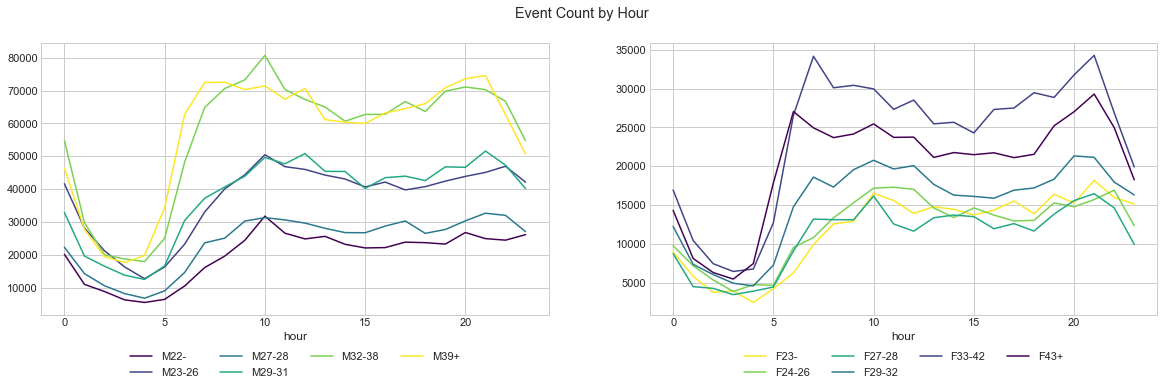

In [331]:
#demographic by hour split by gender.
f, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,5))

plt.suptitle("Event Count by Hour")

time_data[time_data.gender == 'M'].pivot_table(index='hour', columns='group', values='age', aggfunc='count').plot(ax=ax1, cmap='viridis')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4)
   
time_data[time_data.gender == 'F'].pivot_table(index='hour', columns='group', values='age', aggfunc='count').plot(ax=ax2, cmap='viridis_r')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4)

plt.show()

The trends between the hour and day of week do not seem to be that different between men and women. It looks like we just about all have the same habits overall. I will use month, day of week, and hour instead of epoch for my feature space.

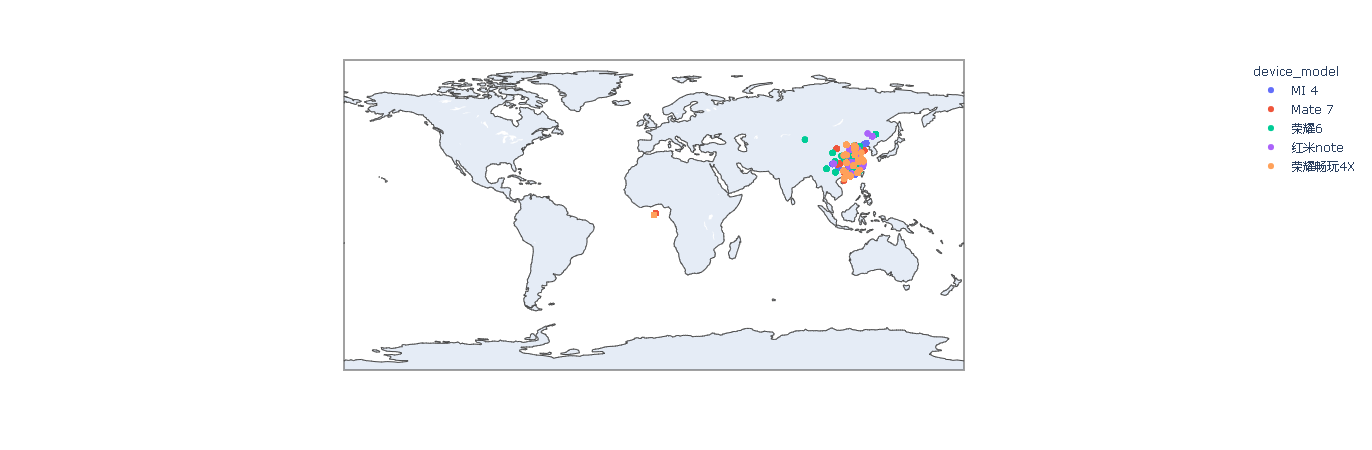

In [91]:
#who is it that I have out in the ocean? The map times out on the entire dataset. What size do I want this to be anyway?
px.scatter_geo(data_frame=time_data, lat='latitude', lon="longitude", scope='world', color='device_model')

In [11]:
#7M is too much for the geo plot to handle, use a sample of 2000. 
map_data = talkdata.sample(n=2000)
map_data.shape

(2000, 13)

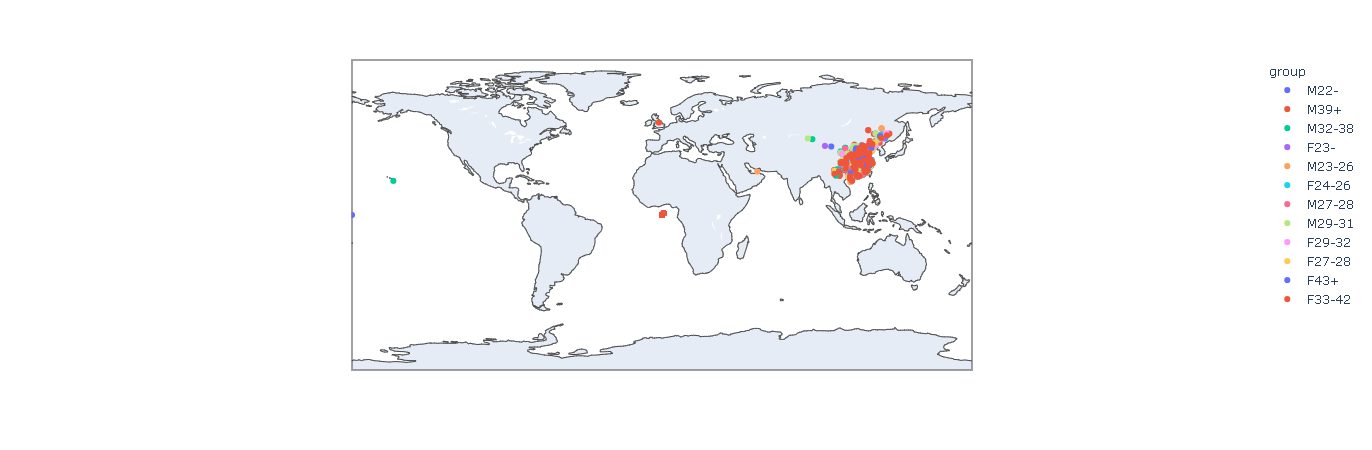

In [14]:
#who is it that I have out in the ocean? The map times out on the entire dataset. What size do I want this to be anyway?
px.scatter_geo(data_frame=map_data, lat='latitude', lon="longitude", scope='world', color='group')

# Conclusion

According to these visualizations; I can see that people all over the world are using these devices. A lot of people are in China. 

The location seems to have very little to do with these demographics. We're using all kinds of devices all the time in all different locations.

Ages and genders do appear to play a role in device and model selection. It does appear that with this information, I should be able to predict a person's gender and age demographic based on the information provided by the device their using. 

I will be using a few different models including gradient boosting, random forest, and decision trees to predict the group/demographic. I will use an unsupervised learning model to cluster the data and weigh those results against the targets. Last, I will construct a deep learning model to further predict the group. The best resulting scores will be coming from a classification report - and maybe an AUC score. 

With over seven million records against an imbalanced dataset and over 34,000 categories to classify against; I have quite the challenge ahead of me. 

In [374]:
talkdata.head()

,timestamp,longitude,latitude,coordinates,is_active,phone_brand,device_model,category,gender,age,group,tTime,epoch,device_type
0,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,1 free,M,35,M32-38,2016-05-01 14:23:37,1462112617000000000,小米 MI 2
1,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,Cozy 1,M,35,M32-38,2016-05-01 14:23:37,1462112617000000000,小米 MI 2
2,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,Industry tag,M,35,M32-38,2016-05-01 14:23:37,1462112617000000000,小米 MI 2
3,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,Property Industry 2.0,M,35,M32-38,2016-05-01 14:23:37,1462112617000000000,小米 MI 2
4,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,music,M,35,M32-38,2016-05-01 14:23:37,1462112617000000000,小米 MI 2


This will be a classification project where in I predict the gender and age based on several categorical variables. The following feature engineering needs to be accomplished after importing the table and prior to modeling.

1. Derive the following columns from timestamp:

> Week

> DayofWeek

> Hour

2. Concatenate the phone brand and device_model attributes together in a new column. 
3. Remove timestamp, tTime, epoch, longitude, latitude, phone_brand, device_model, gender, age
4. Set the target variable, y to the group column. Remove the target variable from the feature set. 
5. Perform a train_test split on the data. Ensure that the stratisfy parameter is set to group.
6. OneHotEncode all categorical variables.  

In [336]:
talkdata.nunique()

timestamp       497663
longitude         2914
latitude          2707
coordinates      32921
is_active            2
phone_brand         89
device_model       926
category           441
gender               2
age                 78
group               12
tTime           497663
epoch           497663
dtype: int64

In [341]:
#Expected size of feature space after conversion:
talkdata.coordinates.nunique() + talkdata.is_active.nunique() + talkdata.device_model.nunique() + talkdata.category.nunique() + 6 + 22 - 4 + 2

34316